In [1]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

In [4]:
in_dir = "data/"
ct = dicom.read_file('Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

(512, 512)
int16


Exercise 1: The spleen typically has HU units in the range of 0 to 150. Try to make a good visualization of the CT scan and spleen using (replace the question marks with values):



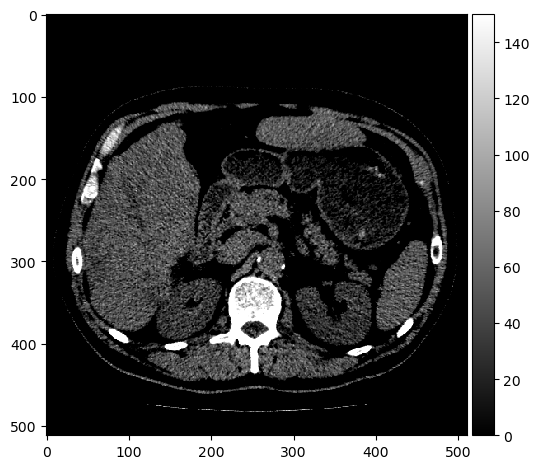

In [5]:
io.imshow(img, vmin=0, vmax=150, cmap='gray')
io.show()

In [8]:
spleen_roi = io.imread('SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]

Exercise 2: Compute the average and standard deviation of the Hounsfield units found in the spleen in the training image. Do they correspond to the values found in the above figure?

In [20]:
mu_spleen = spleen_values.mean()
std_spleen = spleen_values.std()
print(f'Average: {mu_spleen}')
print(f'Standard deviation: {std_spleen}')

Average: 49.48026905829597
Standard deviation: 14.9970794143059


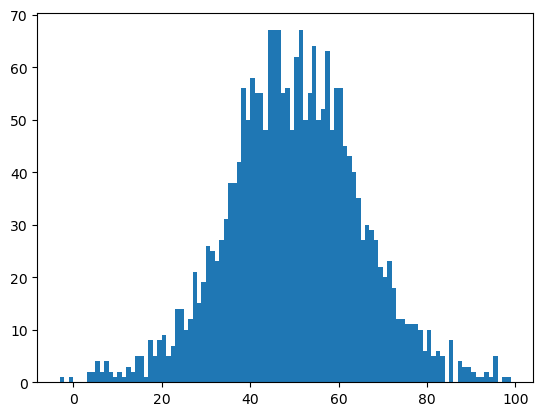

In [19]:
plt.hist(spleen_values, bins=spleen_values.max()-spleen_values.min())
plt.show()

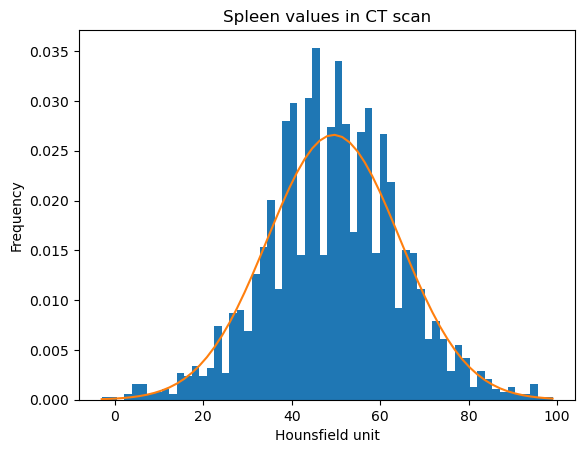

In [23]:
n, bins, patches = plt.hist(spleen_values, 60, density=1)
pdf_spleen = norm.pdf(bins, mu_spleen, std_spleen)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

Exercise 4: Plot histograms and their fitted Gaussians of several of the tissues types. Do they all look like they are Gaussian distributed?



In [58]:
def plot_histogram_and_fitted_gaussian(tissue_type):
    filename = tissue_type + 'ROI.png'
    roi = io.imread(filename)
    mask = roi > 0
    values = img[mask]
    mu = values.mean()
    std = values.std()
    _, bins, _ = plt.hist(values, 60, density=1)
    pdf_bone = norm.pdf(bins, mu, std)
    plt.plot(bins, pdf_bone)
    plt.xlabel('Hounsfield unit')
    plt.ylabel('Frequency')
    plt.title(tissue_type + ' values in CT scan')
    return mu, std

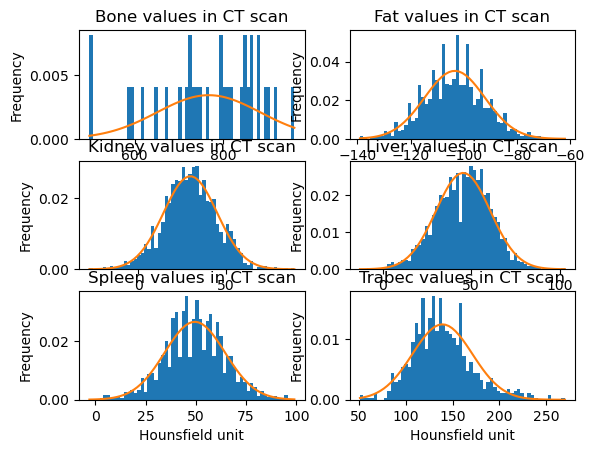

In [73]:
tissues = ['Bone', 'Fat', 'Kidney', 'Liver', 'Spleen', 'Trabec']
statistics = {tissue: {'mu': 0, 'std': 0} for tissue in tissues}
i = 1

for tissue in tissues:
    plt.subplot(3, 2, i)
    mu, std = plot_histogram_and_fitted_gaussian(tissue)
    statistics[tissue]['mu'] = mu
    statistics[tissue]['std'] = std
    i += 1
plt.show()


Exercise 5: Plot the fitted Gaussians of bone, fat, kidneys, liver and spleen. What classes are easy to seperate and which classes are hard to seperate?



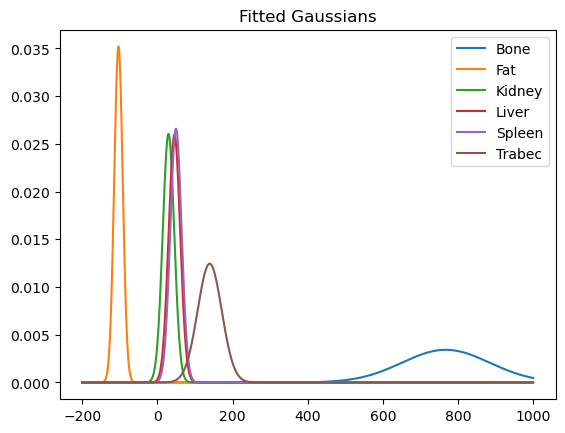

In [75]:
# Hounsfield unit limits of the plot
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
for tissue in tissues:
    pdf = norm.pdf(hu_range, statistics[tissue]['mu'], statistics[tissue]['std'])
    plt.plot(hu_range, pdf, label=tissue)

plt.title("Fitted Gaussians")
plt.legend()
plt.show()

Exercise 6: Define the classes that we aim at classifying. Perhaps some classes should be combined into one class?

*Fat, Trabec and Bone are differentiable classes. We could combine Kidney, Liver and Spleen into one class.*

Exercise 7: Compute the class ranges defining fat, soft tissue and bone.



In [89]:
soft_tissues = ['Spleen', 'Liver', 'Kidney']
t_background = -200
t_fat_soft = (statistics['Fat']['mu'] + sum(statistics[tissue]['mu'] for tissue in soft_tissues)) / 4
t_soft_bone = (statistics['Bone']['mu'] + sum(statistics[tissue]['mu'] for tissue in soft_tissues)) / 4

Exercise 8: Create class images: fat_img, soft_img and bone_img representing the fat, soft tissue and bone found in the image.



In [90]:
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img  = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = (img > t_soft_bone)

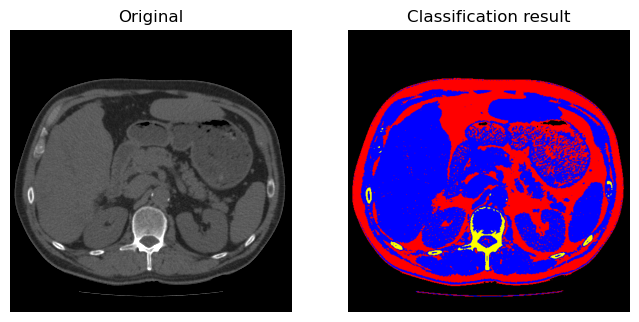

In [91]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

Exercise 8': Visualize your classification result and compare it to the anatomical image in the start of the exercise. Does your results look plausible?

*Yes, looks plausible*

Exercise 9: Plot the fitted Gaussians of the training values and manually find the intersection between the curves.



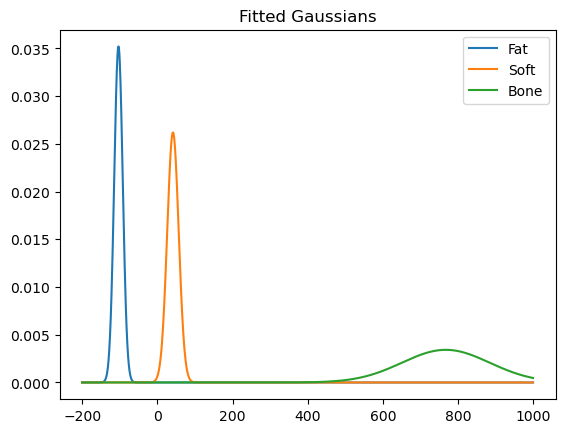

In [92]:
# Hounsfield unit limits of the plot
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_fat = norm.pdf(hu_range, statistics['Fat']['mu'], statistics['Fat']['std'])
pdf_soft = norm.pdf(hu_range, sum(statistics[tissue]['mu'] for tissue in soft_tissues)/3, sum(statistics[tissue]['std'] for tissue in soft_tissues)/3)
pdf_bone = norm.pdf(hu_range, statistics['Bone']['mu'], statistics['Bone']['std'])

plt.plot(hu_range, pdf_fat, label='Fat')
plt.plot(hu_range, pdf_soft, label='Soft')
plt.plot(hu_range, pdf_bone, label='Bone')

plt.title("Fitted Gaussians")
plt.legend()
plt.show()

Exercise 10: Use the same technique as in exercise 7, 8 and 9 to visualize your classification results. Did it change compared to the minimum distance classifier?



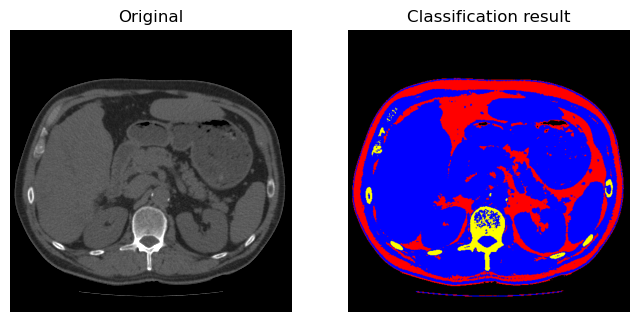

In [122]:
t_background = -200
t_fat_soft = -41
t_soft_bone = 130

fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img  = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = (img > t_soft_bone)

label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

Exercise 11: Use norm.pdf to find the optimal class ranges between fat, soft tissue and bone.



In [123]:
mu_soft = sum(statistics[tissue]['mu'] for tissue in soft_tissues)/3
std_soft =sum(statistics[tissue]['std'] for tissue in soft_tissues)/3
test_value = 130
if norm.pdf(test_value, mu_soft, std_soft) > norm.pdf(test_value, statistics['Bone']['mu'], statistics['Bone']['std']):
	print(f"For value {test_value} the class is soft tissue")
else:
	print(f"For value {test_value} the class is bone")

For value 130 the class is soft tissue


In [124]:
mu_soft = sum(statistics[tissue]['mu'] for tissue in soft_tissues)/3
std_soft =sum(statistics[tissue]['std'] for tissue in soft_tissues)/3
test_value = -41
if norm.pdf(test_value, statistics['Fat']['mu'], statistics['Fat']['std']) > norm.pdf(test_value, mu_soft, std_soft):
	print(f"For value {test_value} the class is fat")
else:
	print(f"For value {test_value} the class is soft tissue")

For value -41 the class is soft tissue


Exercise 11: Inspect the values of the spleen as in exercise 3 and select a lower and upper threshold to create a spleen class range.



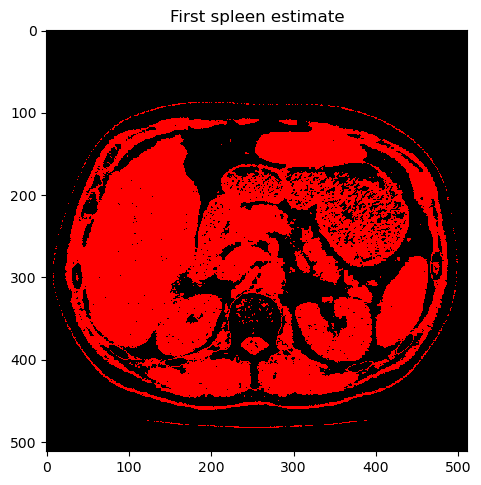

In [125]:
t_1 = -3 
t_2 = 99
spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

Exercise 12: Use the above morphological operations to seperate the spleen from other organs and close holes. Change the values where there are question marks to change the size of the used structuring elements.



In [126]:
footprint = disk(3)
closed = binary_closing(spleen_estimate, footprint)

footprint = disk(5)
opened = binary_opening(closed, footprint)

In [127]:
label_img = measure.label(opened)

Exercise 13: Inspect the labeled image and validate the success of separating the spleen from the other objects. If it is connected (have the same color) to another organ, you should experiment with the kernel sizes in the morphological operations.



In [ ]:
min_area = 5
max_area = 20

# Create a copy of the label_img
label_img_filter = label_img.copy()
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area')